
# **COMP9414 Artificial Intelligence**
## Assignment 1: Constraint Satisfaction Search

@Authors: **Wayne Wobcke, Alfred Krzywicki, Stefano Mezza**

**Due Date:** Week 5, Friday, October 17, 5.00pm

### Objective

This assignment concerns developing optimal solutions to a scheduling problem inspired by the scenario of a manufacturing plant that has to fulfil multiple customer orders with varying deadlines, but where there may be constraints on tasks and on relationships between tasks. Any number of tasks can be scheduled at the same time, but it is possible that some tasks cannot be finished before their deadline. A task finishing late is acceptable, however incurs a cost, which for this assignment is a simple (dollar) amount per hour that the task is late.

A *fuzzy scheduling* problem in this scenario is simplified by ignoring customer orders and having just one machine and a number of *tasks*, each with a fixed duration in hours. Each task must start and finish on the same day, within working hours (9am to 5pm). In addition, there can be *constraints*, both on single tasks and between two tasks. One type of constraint is that a task can have a deadline, which can be “hard” (the deadline must be met in any valid schedule) or “soft” (the task may be finished late &ndash; though still at or before 5pm &ndash; but with a “cost” per hour for missing the deadline). The aim is to develop an overall schedule for all the tasks (in a single week) that minimizes the total cost of all the tasks that finish late, provided that all the hard constraints on tasks are satisfied.

More technically, this assignment is an example of a *constraint optimization problem* (or *constrained optimization problem*), a problem that has constraints like a standard Constraint Satisfaction Problem (CSP), but also a *cost* associated with each solution. For this assignment, we will use a *greedy* algorithm to find optimal solutions to fuzzy scheduling problems that are specified as text strings. However, unlike the greedy search algorithm described in the lectures on search, this greedy algorithm has the property that it is guaranteed to find an optimal solution for any problem (if a solution exists).

The assignment will use the AIPython code of Poole & Mackworth. You are given code to translate fuzzy scheduling problems specified as text strings into CSPs with a cost, and you are given code for several constraint solving algorithms &ndash; based on domain splitting and arc consistency, and based on depth-first search. The assignment will be to implement some missing procedures and to analyse the performance of the constraint solving methods, both analytically and experimentally.

### Submission Instructions

- This is an individual assignment.

- Write your answers in **this** notebook and submit **this** notebook on Moodle under **Assignment 1**.

- Name your submission ``<zid>-<firstname>-<lastname>.ipynb`` where ``<firstname>-<lastname>`` is your **real** (not Moodle) name.

- Make sure you set up AIPython (as done below) so the code can be run on either CSE machines or a marker's own machine.

- Do not submit any AIPython code. Hence do not change any AIPython code to make your code run.

- Make sure your notebook runs cleanly (restart the kernel, clear all outputs and run each cell to check).

- After checking that your notebook runs cleanly, run all cells and submit the notebook **with** the outputs included (do not submit the empty version).

- Make sure images (for plots/graphs) are **included** in the notebook you submit (sometimes images are saved on your machine but are not in the notebook).

- Do not modify the existing code in this notebook except to answer the questions. Marks will be given as and where indicated.

- If you want to submit additional code (e.g. for generating plots), add that at the end of the notebook.

- **Important: Do not distribute any of this code on the Internet. This includes ChatGPT. Do not put this assignment into any LLM.**

### Late Penalties

Standard UNSW late penalties apply (5% of the value of the assignment per day or part day late).

**Note:** Unlike the CSE systems, there is no grace period on Moodle. The due date and time is 5pm **precisely** on Friday October 17.

**Important: You can submit as many times as you want before the due date, but if you do submit before the due date, you cannot submit on Moodle after the due date. If you do not submit before the due date, you can submit on Moodle after the due date.**

### Plagiarism

Remember that ALL work submitted for this assignment must be your own work and no sharing or copying of code or answers is allowed. You may discuss the assignment with other students but must not collaborate on developing answers to the questions. You may use code from the Internet only with suitable attribution of the source. You may not use ChatGPT or any similar software to generate any part of your explanations, evaluations or code. Do not use public code repositories on sites such as github or file sharing sites such as Google Drive to save any part of your work &ndash; make sure your code repository or cloud storage is private and do not share any links. This also applies after you have finished the course, as we do not want next year’s students accessing your solution, and plagiarism penalties can still apply after the course has finished.

All submitted assignments will be run through plagiarism detection software to detect similarities to other submissions, including from past years. You should **carefully** read the UNSW policy on academic integrity and plagiarism (linked from the course web page), noting, in particular, that collusion (working together on an assignment, or sharing parts of assignment solutions) is a form of plagiarism.

Finally, do not use any contract cheating “academies” or online “tutoring” services. This counts as serious misconduct with heavy penalties up to automatic failure of the course with 0 marks, and expulsion from the university for repeat offenders.

### Fuzzy Scheduling

A CSP for this assignment is a set of variables representing tasks, binary constraints on pairs of tasks, and unary constraints (hard or soft) on tasks. The domains are all the working hours in one week, and a task duration is in hours. Days are represented (in the input and output) as strings ‘mon’, ‘tue’, ‘wed’, ‘thu’ and ‘fri’, and times are represented as strings ‘9am’, ‘10am’, ‘11am’, ‘12pm’, ‘1pm’, ‘2pm’, ‘3pm’, ‘4pm’ and ‘5pm’. The only possible values for the start and end times of a task are combinations of a day and times, e.g. ‘mon 9am’. Each task name is a string (with no spaces), and the only soft constraints are the soft deadline constraints.

There are three types of constraint:

- **Binary Constraints:** These specify a hard requirement for the relationship between two tasks.
- **Hard Domain Constraints:** These specify hard requirements for the tasks themselves.
- **Soft Deadline Constraints:** These constraints specify that a task may finish late, but with a given cost.

Each soft constraint has a function defining the *cost* associated with violating the preference, that the constraint solver must minimize, while respecting all the hard constraints. The *cost* of a solution is simply the sum of the costs for the soft constraints that the solution violates (and is always a non-negative integer).

This is the list of possible constraints for a fuzzy scheduling problem (comments below are for explanation and do **not** appear in the input specification; however, the code we supply *should* work with comments that take up a full line): 

```
# binary constraints
constraint, ⟨t1⟩ before ⟨t2⟩           # t1 ends when or before t2 starts
constraint, ⟨t1⟩ after ⟨t2⟩            # t1 starts after or when t2 ends
constraint, ⟨t1⟩ same-day ⟨t2⟩         # t1 and t2 are scheduled on the same day
constraint, ⟨t1⟩ starts-at ⟨t2⟩        # t1 starts exactly when t2 ends

# hard domain constraints
domain, ⟨t⟩, ⟨day⟩, hard                                    # t starts on given day at any time
domain, ⟨t⟩, ⟨time⟩, hard                                   # t starts at given time on any day
domain, ⟨t⟩, starts-before ⟨day⟩ ⟨time⟩, hard               # t starts at or before day, time
domain, ⟨t⟩, starts-after ⟨day⟩ ⟨time⟩, hard                # t starts at or after day, time
domain, ⟨t⟩, ends-before ⟨day⟩ ⟨time⟩, hard                 # t ends at or before day, time
domain, ⟨t⟩, ends-after ⟨day⟩ ⟨time⟩, hard                  # t starts at or after day, time
domain, ⟨t⟩, starts-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard  # day-time range for start time; includes day1, time1 and day2, time2
domain, ⟨t⟩, ends-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard    # day-time range for end time; includes day1, time1 and day2, time2
domain, ⟨t⟩, starts-before ⟨time⟩, hard                     # t starts at or before time on any day
domain, ⟨t⟩, ends-before ⟨time⟩, hard                       # t ends at or before time on any day
domain, ⟨t⟩, starts-after ⟨time⟩, hard                      # t starts at or after time on any day
domain, ⟨t⟩, ends-after ⟨time⟩, hard                        # t ends at or after time on any day

# soft deadline constraint
domain, ⟨t⟩, ends-by ⟨day⟩ ⟨time⟩ ⟨cost⟩, soft          # cost per hour of missing deadline
```

The input specification will consist of several “blocks”, listing the tasks, binary constraints, hard unary constraints and soft deadline constraints for the given problem. A “declaration” of each task will be included before it is used in a constraint. A sample input specification is as follows. Comments are for explanation and do **not** have to be included in the input.

```
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadline constraints
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
```

## Preparation

### 1. Set up AIPython

You will need AIPython for this assignment. To find the aipython files, the aipython directory has to be added to the Python path.

Do this temporarily, as done here, so we can find AIPython and run your code (you will not submit any AIPython code).

You can add either the full path (using `os.path.abspath`), or as in the code below, the relative path.

In [2]:
import sys
sys.path.append('d:\\25T3 9414\\aipython') # change to your directory
sys.path # check that aipython is now on the path

['d:\\Anaconda-Navigator\\envs\\python311\\python311.zip',
 'd:\\Anaconda-Navigator\\envs\\python311\\DLLs',
 'd:\\Anaconda-Navigator\\envs\\python311\\Lib',
 'd:\\Anaconda-Navigator\\envs\\python311',
 '',
 'd:\\Anaconda-Navigator\\envs\\python311\\Lib\\site-packages',
 'd:\\Anaconda-Navigator\\envs\\python311\\Lib\\site-packages\\win32',
 'd:\\Anaconda-Navigator\\envs\\python311\\Lib\\site-packages\\win32\\lib',
 'd:\\Anaconda-Navigator\\envs\\python311\\Lib\\site-packages\\Pythonwin',
 'd:\\25T3 9414\\aipython']

### 2. Representation of Day Times

Input and output are day time strings such as 'mon 10am' or a range of day time strings such as 'mon 10am-mon 4pm'.

The CSP will represent these as integer hour numbers in the week, ranging from 0 to 39.

The following code handles the conversion between day time strings and hour numbers.

In [3]:
# -*- coding: utf-8 -*-
    
""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""
class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        value = None
        value_type = None
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0].strip()
            if str1 in self.time_names: # this is a time
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            else:
                value = self.day_names.index(str1) # this is a day
                value_type = 'day_number'
            # if not day or time, throw an exception
        else:
            value = self.day_names.index(day_time_list[0].strip())*self.num_hours_in_day \
                + self.time_names.index(day_time_list[1].strip())
            value_type = 'week_hour_number'
        return (value_type, value)

    def string_to_number_set(self, day_time_list_str):
        """ convert a list of day-times or ranges 'Mon 9am, Tue 9am-Tue 4pm' into a list of integer hours in the week
            e.g. 'mon 9am-1pm, mon 4pm' -> [0,1,2,3,4,7]
        """
        number_set = set()
        type1 = None
        for str1 in day_time_list_str.lower().split(','):
            if str1.find('-') > 0:
                # day time range
                type1, v1 = self.string_to_week_hour_number(str1.split('-')[0].strip())
                type2, v2 = self.string_to_week_hour_number(str1.split('-')[1].strip())
                if type1 != type2: return None # error, types in range spec are different
                number_set.update({n for n in range(v1, v2+1)})
            else:
                # single day time
                type2, value2 = self.string_to_week_hour_number(str1)
                if type1 != None and type1 != type2: return None # error: type in list is inconsistent
                type1 = type2
                number_set.update({value2})
        return (type1, number_set)
    
    # convert integer hour in week to day time string
    def week_hour_number_to_day_time(self, week_hour_number):
        hour = self.day_hour_number(week_hour_number)
        day = self.day_number(week_hour_number)
        return self.day_names[day]+' '+self.time_names[hour]
    
    # convert integer hour in week to integer day and integer time in day
    def hour_day_split(self, week_hour_number):
        return (self.day_hour_number(week_hour_number), self.day_number(week_hour_number))
    
    # convert integer hour in week to integer day in week
    def day_number(self, week_hour_number):
        return int(week_hour_number / self.num_hours_in_day)
    
    # convert integer hour in week to integer time in day
    def day_hour_number(self, week_hour_number):
        return week_hour_number % self.num_hours_in_day
    
    def __repr__(self):
        day_hour_number = self.week_hour_number % self.num_hours_in_day
        day_number = int(self.week_hour_number / self.num_hours_in_day)
        return self.day_names[day_number]+' '+self.time_names[day_hour_number]

### 3. Constraint Satisfaction Problems with Costs over Tasks with Durations

Since AI Python does not provide the CSP class with an explicit cost, we implement our own class that extends `CSP`.

We also store the cost functions and the durations of all tasks explicitly in the CSP.

The durations of the tasks are used in the `hold` function to evaluate constraints.

In [4]:
from cspProblem import CSP, Constraint

# We need to override Constraint, because tasks have durations
class Task_Constraint(Constraint):
    """A Task_Constraint consists of
    * scope: a tuple of variables
    * spec: text description of the constraint used in debugging
    * condition: a function that can applied to a tuple of values for the variables
    * durations: durations of all tasks
    * func_key: index to the function used to evaluate the constraint
    """
    def __init__(self, scope, spec, condition, durations, func_key):
        super().__init__(scope, condition, spec)
        self.scope = scope
        self.condition = condition
        self.durations = durations
        self.func_key = func_key

    def holds(self, assignment):
        """returns the value of Constraint con evaluated in assignment.

        precondition: all variables are assigned in assignment
        
        CSP has only binary constraints
        condition is in the form week_hour_number1, week_hour_number2
        add task durations as appropriate to evaluate condition
        """
        if self.func_key == 'before':
            # t1 ends before t2 starts, so we need add duration to t1 assignment
            ass0 = assignment[self.scope[0]] + self.durations[self.scope[0]]
            ass1 = assignment[self.scope[1]]
        elif self.func_key == 'after':
            # t2 ends before t1 starts so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        elif self.func_key == 'starts-at':
            # t1 starts exactly when t2 ends, so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        else:
            return self.condition(*tuple(assignment[v] for v in self.scope))    
        # condition here comes from get_binary_constraint
        return self.condition(*tuple([ass0, ass1]))

# implement nodes as CSP problems with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a task name, to a list of functions for the constraints that apply """
    def __init__(self, domains, durations, constraints, cost_functions, soft_day_time, soft_costs):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.durations = durations
        self.cost_functions = cost_functions
        self.soft_day_time = soft_day_time
        self.soft_costs = soft_costs
        self.cost = self.calculate_cost()

    # specific to fuzzy scheduling CSP problems
    def calculate_cost(self):
        """ this is really a function f = path cost + heuristic to be used by the constraint solver """
        # variable setup
        task_to_domain = self.domains
        task_to_duration = self.durations
        task_to_soft_deadline = self.soft_day_time
        task_to_hourly_soft_cost = self.soft_costs

        day_time_helper = Day_Time()
        total_cost = 0

        def extract_one_week_hour(deadline_string):
            """
            Parses a day-time string and returns a single integer representing the hour in the week.
            Returns None if the string is invalid or doesn't represent a specific hour.
            """
            if not deadline_string:
                return None
            
            parsed_type, parsed_values = day_time_helper.string_to_number_set(deadline_string)
            if parsed_type == "week_hour_number" and parsed_values:
                return next(iter(parsed_values))
            return None

        for task_name, domain_values in task_to_domain.items():
            best_cost_for_task = float("inf")

            duration_of_task = task_to_duration.get(task_name, 0)
            soft_deadline_string = task_to_soft_deadline.get(task_name, None)
            raw_hourly_cost = task_to_hourly_soft_cost.get(task_name, 0)

            resolved_deadline = extract_one_week_hour(soft_deadline_string)
            
            for start_hour in domain_values:
                if resolved_deadline is None:
                    computed_penalty = 0
                else:
                    task_end_hour = start_hour + duration_of_task
                    lateness_amount = task_end_hour - resolved_deadline
                    if lateness_amount < 0:
                        lateness_amount = 0
                    computed_penalty = lateness_amount * int(raw_hourly_cost)

                if computed_penalty < best_cost_for_task:
                    best_cost_for_task = computed_penalty

            if best_cost_for_task == float("inf"):
                best_cost_for_task = 0

            total_cost += best_cost_for_task
            
        return int(total_cost)

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"

This formulates a solver for a CSP with cost as a search problem, using domain splitting with arc consistency to define the successors of a node.

In [5]:
from cspConsistency import Con_solver, select, partition_domain 
from searchProblem import Arc, Search_problem
from operator import eq, le, ge

# rewrites rather than extends Search_with_AC_from_CSP
class Search_with_AC_from_Cost_CSP(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        self.durations = csp.durations
        self.soft_day_time = csp.soft_day_time
        self.soft_costs = csp.soft_costs
        csp.domains = self.domains # after arc consistency
        self.csp = csp

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return CSP_with_Cost(self.domains, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)

    def neighbors(self, node):
        """returns the neighboring nodes of node.
        """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            dom1, dom2 = partition_domain(node.domains[var])
            self.display(2, "Splitting", var, "into", dom1, "and", dom2)
            to_do = self.cons.new_to_do(var, None)
            for dom in [dom1,dom2]:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs    
    
    def heuristic(self, n):
        return n.cost

### 4. Fuzzy Scheduling Constraint Satisfaction Problems

The following code sets up a CSP problem from a given specification.

Hard (unary) domain constraints are applied to reduce the domains of the variables before the constraint solver runs.

In [6]:
# domain specific CSP builder for week schedule
class CSP_builder():
    # list of text lines without comments and empty lines
    _, default_domain = Day_Time().string_to_number_set('mon 9am-fri 4pm') # should be 0,...,39
    
    # hard unary constraints: domain is a list of values, params is a single value
    # starts-before, ends-before (for starts-before duration should be 0)
    # vals in domain are actual task start/end date/time, so must be val <= whatever is in params
    def apply_before(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 > param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_after(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 < param_val:
                if val in domain: domain.remove(val)
        return domain
    
    # day time range only
    # includes starts-in, ends-in
    # duration is 0 for starts-in, task duration for ends-in
    def apply_in(self, params, duration, domain):
        domain_orig = domain.copy()
        for val in domain_orig: # val is week_hour_number
            # task must be within range
            if val in domain and val+duration not in params:
                domain.remove(val)
        return domain
    
    # task must start at day/time    
    def apply_at(self, param_type, param,domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and param != h:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and param != d:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and param != val:
                if val in domain: domain.remove(val)
        return domain

    # soft deadline constraints: return cost to break constraint
    # ends-by implementation: domain_dt is the day, hour from the domain
    # constr_dt is the soft const spec, dur is the duration of task
    # soft_cost is the unit cost of completion delay
    # so if the tasks starts on domain_dt, it ends on domain_dt+dur
    """
    <t> ends-by <day> <time>, both must be specified
    delay = day_hour(T2) – day_hour(T1) + 24*(D2 - D1), 
    where day_hour(9am) = 0, day_hour(5pm) = 7
    """
    def ends_by(self, domain_dt, constr_dt_str, dur, soft_cost):
        param_type,params = Day_Time().string_to_number_set(constr_dt_str)
        param_val = params.pop()
        dom_h, dom_d = Day_Time().hour_day_split(domain_dt+dur)
        if param_type == 'week_hour_number':
            con_h, con_d = Day_Time().hour_day_split(param_val)
            return 0 if domain_dt + dur <= param_val else soft_cost*(dom_h - con_h + 24*(dom_d - con_d))
        else:
           return None # not good, must be day and time
    
    def no_cost(self, day ,hour):
        return 0
    
    # hard binary constraint, the rest are implemented as gt, lt, eq
    def same_day(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return d1 == d2
        
    # domain is a list of values
    def apply_hard_constraint(self, domain, duration, spec):
        tokens = func_key = spec.split(' ')
        if len(tokens) > 1:
           func_key = spec.split(' ')[0].strip()
           param_type, params = Day_Time().string_to_number_set(spec[len(func_key):])
           if func_key == 'starts-before':
              # duration is 0 for starts before, since we do not modify the time
              return self.apply_before(param_type, params, 0, domain)
           if func_key == 'ends-before':
               return self.apply_before(param_type, params, duration, domain)
           if func_key == 'starts-after':
              return self.apply_after(param_type,params,0,domain)
           if func_key == 'ends-after':
              return self.apply_after(param_type, params, duration, domain)
           if func_key == 'starts-in':
               return self.apply_in(params, 0, domain)
           if func_key == 'ends-in':
               return self.apply_in(params, duration, domain)
        else:
           # here we have task day or time, it has no func key so we need to parse again
           param_type,params = Day_Time().string_to_week_hour_number(spec)
           return self.apply_at(param_type, params, domain)
           
    def get_cost_function(self, spec):
        func_dict = {'ends-by':self.ends_by, 'no-cost':self.no_cost}
        return [func_dict[spec]]
    
    # spec is the text of a constraint, e.g. 't1 before t2'
    # durations are durations of all tasks
    def get_binary_constraint(self, spec, durations):
        tokens = spec.strip().split(' ')
        if len(tokens) != 3: return None # error in spec
        # task1 relation task2
        fun_dict = {'before':le, 'after':ge, 'starts-at':eq, 'same-day':self.same_day}
        return Task_Constraint((tokens[0].strip(), tokens[2].strip()), spec, fun_dict[tokens[1].strip()], durations, tokens[1].strip())
    
    def get_CSP_with_Cost(self, input_lines):
        # Note: It would be more elegant to make task a class but AIpython is not designed for this:
        # CSP_with_Cost inherits from CSP, which takes domains and constraints from all tasks instead of tasks themselves
        domains = dict()
        constraints = []
        cost_functions = dict()
        durations = dict() # durations of tasks
        soft_day_time = dict() # day time specs of soft constraints
        soft_costs = dict() # costs of soft constraints
        
        for input_line in input_lines:
            func_spec = None
            input_line_tokens = input_line.strip().split(',')
            if len(input_line_tokens) != 2: 
                return None # must have number of tokens = 2
            line_token1 = input_line_tokens[0].strip()
            line_token2 = input_line_tokens[1].strip()
            if line_token1 == 'task':
                tokens = line_token2.split(' ')
                if len(tokens) != 2: 
                    return None # must have number of tokens = 3
                key = tokens[0].strip()
                # check the duration and save it
                duration = int(tokens[1].strip())
                if duration > Day_Time().num_hours_in_day: 
                    return None
                durations[key] = duration
                # set zero cost function for this task as default, may add real cost later
                cost_functions[key] = self.get_cost_function('no-cost')
                soft_costs[key] = '0'
                soft_day_time[key] = 'fri 5pm'
                # restrict domain to times that are within allowed range
                # that is start 9-5, start+duration in 9-5
                domains[key] = {x for x in self.default_domain \
                                if Day_Time().day_number(x+duration) \
                                == Day_Time().day_number(x)}
            elif line_token1 == 'domain':
                tokens = line_token2.split(' ')
                if len(tokens) < 2: 
                    return None # must have number of tokens >= 2
                key = tokens[0].strip()
                # if soft constraint, it is handled differently from hard constraints
                if tokens[1].strip() == 'ends-by':
                    # need to retain day time and cost from the line
                    # must have task, 'end-by', day, time, cost
                    # or task, 'end-by', day, cost
                    # or task, 'end-by', time, cost
                    if len(tokens) != 5: 
                        return None 
                    # get the rest of the line after 'ends-by'
                    soft_costs[key] = int(tokens[len(tokens)-1].strip()) # last token is always cost
                    # pass the day time string to avoid passing param_type
                    day_time_str = tokens[2] + ' ' + tokens[3]
                    soft_day_time[key] = day_time_str
                    cost_functions[key] = self.get_cost_function(tokens[1].strip())
                else:
                    # the rest of domain spec, after key, are hard unary domain constraints
                    # func spec has day time, we also need duration
                    dur = durations[key]
                    func_spec = line_token2[len(key):].strip()
                    domains[key] = self.apply_hard_constraint(domains[key], dur, func_spec)       
            elif line_token1 == 'constraint': # all binary constraints
                constraints.append(self.get_binary_constraint(line_token2, durations))
            else:
                return None
            
        return CSP_with_Cost(domains, durations, constraints, cost_functions, soft_day_time, soft_costs)
    
def create_CSP_from_spec(spec: str):
    input_lines = list()    
    spec = spec.split('\n')
    # strip comments
    for input_line in spec:
        input_line = input_line.split('#')
        if len(input_line[0]) > 0:
            input_lines.append(input_line[0])
            print(input_line[0])
    # construct initial CSP problem
    csp = CSP_builder()
    csp_problem = csp.get_CSP_with_Cost(input_lines)
    return csp_problem

### 5. Greedy Search Constraint Solver using Domain Splitting and Arc Consistency

Create a GreedySearcher to search over the CSP.

The *cost* function for CSP nodes is used as the heuristic, but is actually a direct estimate of the total path cost function *f* used in A* Search.

In [7]:
from searchGeneric import AStarSearcher

class GreedySearcher(AStarSearcher):
    """ returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """
    def add_to_frontier(self, path):
        """ add path to the frontier with the appropriate cost """
        # value = path.cost + self.problem.heuristic(path.end()) -- A* definition
        value = path.end().cost
        self.frontier.add(path, value)      

Run the GreedySearcher on the CSP derived from the sample input.

**Note: The solution cost will always be 0 (which is wrong for the sample input) until you write the cost function in the cell above.**

In [8]:
# Sample problem specification

sample_spec = """
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadlines
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
"""

In [9]:
# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 0

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
t1: mon 9am
t2: mon 12pm
cost: 10


### 6. Depth-First Search Constraint Solver

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We need to modify this code to make it compatible with the arc consistency solver.

Run the solver by calling `dfs_solve1` (first solution) or `dfs_solve_all` (all solutions).

In [10]:
num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:])

def dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    return list(dfs_solver(csp.constraints, csp.domains, {}, var_order))

def dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run the Depth-First Solver on the sample problem.

**Note: Again there are no costs calculated.**

In [11]:
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) # set display to True to see nodes expanded

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
Nodes expanded to reach solution: 5
t1: mon 9am
t2: mon 12pm


### 7. Depth-First Search Constraint Solver using Forward Checking with MRV Heuristic

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We redefine the `dfs_solver` methods to implement the MRV (Minimum Remaining Values) heuristic using forward checking.

Because the AIPython code is designed to manipulate domain sets, we also need to redefine `can_evaluate` to handle partial assignments.

In [12]:
num_expanded = 0
display = False

def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order is a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        any_value = list(domains[rem_var])[0]
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: any_value})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run this solver on the sample problem.

**Note: Again there are no costs calculated.**

In [13]:
def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First MRV Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_mrv_dfs_solver(csp_problem) # set display to True to see nodes expanded

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
Nodes expanded to reach solution: 5
t2: mon 12pm
t1: mon 9am


## Assignment

**Name:**  RunDong Tian

**zID:**  z5517860

### Question 1 (4 marks)

Consider the search spaces for the fuzzy scheduling CSP solvers &ndash; domain splitting with arc consistency and the DFS solver (without forward checking).

- Describe the search spaces in terms of start state, successor functions and goal state(s) (1 mark)
- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)
- What is the worst case time and space complexity of the two search algorithms? (1 mark)
- Give one example of a fuzzy scheduling problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

For the second and third part-questions, give the answer in a general form in terms of fuzzy scheduling CSP size parameters.

__Answers for Question 1__

1. I will describe DFS and domain splitting with arc consistency separately.

- 1.1 DFS

  1.1.1 Start state: No variables are assigned initially; the search begins from an empty assignment.

  1.1.2 Successor function: Select an unassigned variable and assign it each possible value in its domain, generating new states step by step.

  1.1.3 Goal state: All variables are assigned a specific value, and all hard constraints are satisfied without exception.

- 1.2 Domain splitting with arc consistency

  1.2.1 Start state: Each variable retains its original domain.

  1.2.2 Successor function: Select a variable with multiple remaining values, split its domain into two subdomains, and apply arc consistency to each subdomain. If propagation causes a subdomain to become empty, delete that branch immediately.

  1.2.3 Goal state: Same as for DFS: all variables are assigned values that satisfy all hard constraints.

2. The answer is as follows:

- 2.1 DFS

  2.1.1 branching factor: In the worst case, we may need to try all possible values for each variable, so the maximum branching factor is d (where d is the size of the largest domain of any variable).

  2.1.2 maximum depth: In the worst case, we need to assign all n variables, so the maximum depth is n (where n is the number of variables).

- 2.2 domain splitting with arc consistency

  2.2.1 branching factor: for this specific method, the branching factor is just 2, mainly because the domain splitting will split the domain into two subdomains every time.

  2.2.2 maximum depth: the same reason, because of the domain splitting, every subdomain will be splitted into two subsubdomains and so on and so forth, so the maximum depth is logn.

3. Worst case time and space complexity of the two search algorithms

- 3.1 DFS

  3.1.1 worst case time: When we considor the worst case, there are $d^n$ possible combinations, and we need to mlutiply the number of hard constraints, but in the big-O notation, we can ignore the influence of constant multiplication, so the worst case time is O($d^n$).

  3.1.2 space complexity: DFS only needs to store the current assignment stack, so the worst-case space complexity is O(n).

- 3.2 domain splitting with arc consistency

  3.2.1 worst case time: As for the worst case, every variable must be assigned by a specific value, so if we assume the number of variable is e, the total node of this case is 2 to power e, indicate we must iterative all the node once, so the worst case time is O($2^e$).

  3.2.2 space complexity: Domain splitting + AC must store domains for all variables at each level of recursion. We assume each domain has at most d values, so the space complexity is O(nd).

4. Consider a fuzzy scheduling problem with n sequential tasks, and this problem has many hard ordering constraints over a large discrete domain. For instance, task1 must finish before task2, task2 must commence within half an hour after the completion of task1, and task2 and task3 must be completed on the same day. 

   The reason why domain splitting with arc consistency is more time-saving than DFS is mainly that many invalid values or value pairs can be discarded at the beginning due to strict hard ordering constraints. In contrast, DFS without forward checking will definitely do the backtracking operations many times. Therefore, in this particular case, the domain splitting with arc consistency method is more efficient than DFS without forward checking.


### Question 2 (5 marks)

Define the *cost* function for a fuzzy scheduling CSP (i.e. a node in the search space for domain splitting and arc consistency) as the total cost of the soft deadline constraints violated for all of the variables, assuming that each variable is assigned one of the best possible values from its domain, where a “best” value for a variable *v* is one that has the lowest cost to violate the soft deadline constraint (if any) for that variable *v*.

- Implement the cost function in the indicated cell and place a copy of the code below (3 marks)
- What is its computational complexity (give a general form in terms of fuzzy scheduling CSP size parameters)? (1 mark)
- Show that the cost function *f* never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

In [14]:
# Code for Question 2
# specific to fuzzy scheduling CSP problems
def calculate_cost(self):
    """ this is really a function f = path cost + heuristic to be used by the constraint solver """
    # variable setup
    task_to_domain = self.domains
    task_to_duration = self.durations
    task_to_soft_deadline = self.soft_day_time
    task_to_hourly_soft_cost = self.soft_costs

    day_time_helper = Day_Time()
    total_cost = 0

    def extract_one_week_hour(deadline_string):
        """
        Parses a day-time string and returns a single integer representing the hour in the week.
        Returns None if the string is invalid or doesn't represent a specific hour.
        """
        if not deadline_string:
            return None
            
        parsed_type, parsed_values = day_time_helper.string_to_number_set(deadline_string)
        if parsed_type == "week_hour_number" and parsed_values:
            return next(iter(parsed_values))
        return None

    for task_name, domain_values in task_to_domain.items():
        best_cost_for_task = float("inf")

        duration_of_task = task_to_duration.get(task_name, 0)
        soft_deadline_string = task_to_soft_deadline.get(task_name, None)
        raw_hourly_cost = task_to_hourly_soft_cost.get(task_name, 0)

        resolved_deadline = extract_one_week_hour(soft_deadline_string)
        
        for start_hour in domain_values:
            if resolved_deadline is None:
                computed_penalty = 0
            else:
                task_end_hour = start_hour + duration_of_task
                lateness_amount = task_end_hour - resolved_deadline
                if lateness_amount < 0:
                    lateness_amount = 0
                computed_penalty = lateness_amount * int(raw_hourly_cost)

            if computed_penalty < best_cost_for_task:
                best_cost_for_task = computed_penalty

        if best_cost_for_task == float("inf"):
            best_cost_for_task = 0

        total_cost += best_cost_for_task
            
    return int(total_cost)

__Answers for Question 2__

1. The cost function had already implemnted in the above area.

2. My code has two nested loop, so the computational time complexity is O(nd)(where n is the total number of tasks, d is the largest number of element in the set, meaning that the possible start time of tasks). The time complexity of extract_one_week_hour function is constant.

3. 

- 3.1 prove never decrease along a path: We know that in the heuristic CSP problem, espically A* Search, the evaluation function is f(n) = g(n) + h(n). 

  Firstly, proving the g(n) never decrease, we assume when n transfrom to $n'$, task T been assigned. When T at n, the value of g(n) is 0, when T at $n'$, it will has a cost absloutely, so g($n'$) = g(n) + cost(T), and according to the above proof, cost(T) >= g(n), so we can get g(n) never decrease. 

  Secondly, proving the h(n) never decrease, the value of h(n) is the sum of the minimum cost of non-assigned tasks. On the one hand, when T is an assigned task, T at n, h(n) is not empty, but when T at $n'$, h(n) is empty, because the cost will transform to g($n'$). On the other hand, when T is a non-assigned task, on the basis of my code, the calculation of my function is the minimum cost, when the domain of a task is narrowed down, the possibility of achieving the minimum cost does not increase, so the distribution of h(n) will hold or increase, it is impossible to decrease. 

  In conclusion, both g(n) and h(n) are never decrease, so the f(n) is never decrease.

- 3.2 explain why this means the search algorithm is optimal: As the search proceeds, tasks are incrementally assigned, expanding the allocation set. Once a complete assignment with the smallest total cost is found, it must be the global optimum. This is because every additional task assignment can only add to or preserve the existing cost, never reduce it. Hence, any cost-driven search function will naturally lead to an optimal solution.

### Question 3 (4 marks)

Conduct an empirical evaluation of the domain splitting CSP solver using the cost function defined as above compared to using no cost function (i.e. the zero cost function, as originally defined in the above cell). Use the *average number of nodes expanded* as a metric to compare the two algorithms. 

- Write a function `generate_problem(n)` that takes an integer `n` and generates a problem specification with `n` tasks and a random set of hard constraints and soft deadline constraints in the correct format for the constraint solvers (2 marks)

Run the CSP solver (with and without the cost function) over a number of problems of size `n` for a range of values of `n`.

- Plot the performance of the two constraint solving algorithms on the above metric against `n` (1 mark)
- Quantify the performance gain (if any) achieved by the use of this cost function (1 mark)

Problem Sizes (n): [3, 5, 7], Trials per size: 10, Max Expanded Nodes: 20000

Performance Medians (Expanded Nodes):
  Zero Cost Baseline: [6, 850, 20000]
  Cost-Aware Heuristic: [45, 30, 1333]


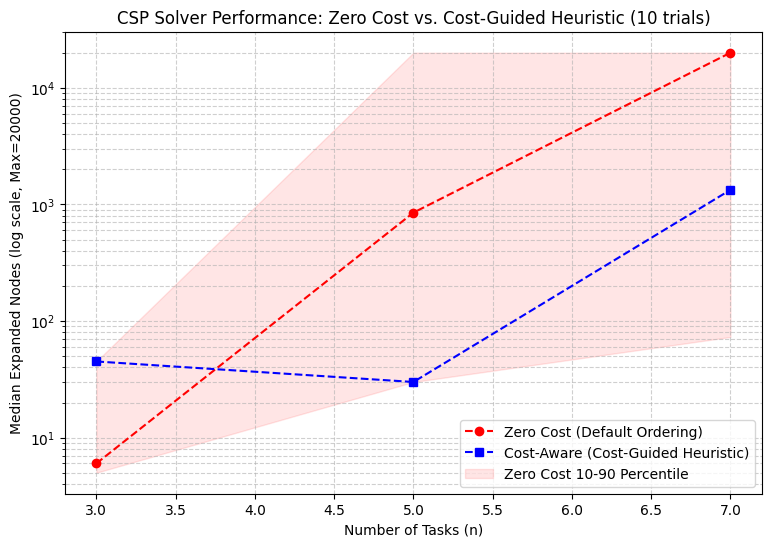


Quantification of performance gain will display in the following area
n=3: Baseline Median=6, Cost-Aware Median=45 --> Node Reduction Gain: -650.00%
n=5: Baseline Median=850, Cost-Aware Median=30 --> Node Reduction Gain: 96.47%
n=7: Baseline Median=20000, Cost-Aware Median=1333 --> Node Reduction Gain: 93.34%

Average Performance Gain over observed sizes: 94.90%


In [ ]:
# Code for Question 3
# -*- coding: utf-8 -*-
from cspProblem import Constraint, CSP
import random
import matplotlib.pyplot as plt

""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""

class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        if not isinstance(day_time_str, str):
            raise ValueError("Expect a string")
        day_time_str = day_time_str.strip().lower()
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0]
            if str1 in self.time_names:  # time only
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            elif str1 in self.day_names:  # day only
                value = self.day_names.index(str1)
                value_type = 'day_number'
            else:
                raise ValueError(f"Unknown single token: {day_time_str}")
        else:
            day = day_time_list[0]
            time = day_time_list[1]
            if day not in self.day_names or time not in self.time_names:
                raise ValueError(f"Bad day/time in '{day_time_str}'")
            value = self.day_names.index(day)*self.num_hours_in_day + self.time_names.index(time)
            value_type = 'week_hour_number'
        return (value_type, value)

    def string_to_number_set(self, day_time_list_str):
        """ 'mon 9am-1pm, mon 4pm' -> (type, set_of_ints) or raise ValueError """
        if not isinstance(day_time_list_str, str):
            raise ValueError("Expect a string")
        number_set = set()
        common_type = None
        for token in day_time_list_str.lower().split(','):
            token = token.strip()
            if not token:
                continue
            if '-' in token:
                left, right = token.split('-', 1)
                t1, v1 = self.string_to_week_hour_number(left.strip())
                t2, v2 = self.string_to_week_hour_number(right.strip())
                if t1 != t2:
                    raise ValueError("Range endpoints have different types")
                if t1 != 'week_hour_number':
                    raise ValueError("Range must be week_hour_number type")
                number_set.update(range(v1, v2+1))
                common_type = t1
            else:
                t, v = self.string_to_week_hour_number(token)
                if common_type is not None and common_type != t:
                    raise ValueError("Mixed types in list")
                common_type = t
                number_set.add(v)
        return (common_type, number_set)

    def __repr__(self):
        return f"Day_Time(days={self.day_names}, times={self.time_names})"


# We need to override Constraint, because tasks have durations
class Task_Constraint(Constraint):
    """A Task_Constraint consists of
    * scope: a tuple of variables
    * spec: text description of the constraint used in debugging
    * condition: a function that can applied to a tuple of values for the variables
    * durations: durations of all tasks
    * func_key: index to the function used to evaluate the constraint
    """
    def __init__(self, scope, spec, condition, durations, func_key):
        super().__init__(scope, condition, spec)
        self.scope = scope
        self.condition = condition
        self.durations = durations
        self.func_key = func_key

    def holds(self, assignment):
        """returns the value of Constraint con evaluated in assignment.

        precondition: all variables are assigned in assignment
        
        CSP has only binary constraints
        condition is in the form week_hour_number1, week_hour_number2
        add task durations as appropriate to evaluate condition
        """
        if self.func_key == 'before':
            # t1 ends before t2 starts, so we need add duration to t1 assignment
            ass0 = assignment[self.scope[0]] + self.durations[self.scope[0]]
            ass1 = assignment[self.scope[1]]
        elif self.func_key == 'after':
            # t2 ends before t1 starts so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        elif self.func_key == 'starts-at':
            # t1 starts exactly when t2 ends, so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        else:
            return self.condition(*tuple(assignment[v] for v in self.scope)) 
        # condition here comes from get_binary_constraint
        return self.condition(*tuple([ass0, ass1]))

# implement nodes as CSP problems with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a task name, to a list of functions for the constraints that apply """
    def __init__(self, domains, durations, constraints, cost_functions, soft_day_time, soft_costs):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.durations = durations
        self.cost_functions = cost_functions
        self.soft_day_time = soft_day_time
        self.soft_costs = soft_costs
        # Calculate cost upon initialization, representing the current heuristic estimate
        self.cost = self.calculate_cost() 

    # specific to fuzzy scheduling CSP problems
    def calculate_cost(self):
        """ this is really a function f = path cost + heuristic to be used by the constraint solver """
        # variable setup
        task_to_domain = self.domains
        task_to_duration = self.durations
        task_to_soft_deadline = self.soft_day_time
        task_to_hourly_soft_cost = self.soft_costs

        day_time_helper = Day_Time()
        total_cost = 0

        def extract_one_week_hour(deadline_string):
            """
            Parses a day-time string and returns a single integer representing the hour in the week.
            Returns None if the string is invalid or doesn't represent a specific hour.
            """
            if not deadline_string:
                return None
            
            # Using string_to_number_set which handles parsing multiple formats
            parsed_type, parsed_values = day_time_helper.string_to_number_set(deadline_string)
            if parsed_type == "week_hour_number" and parsed_values:
                # Assuming the soft constraint deadline corresponds to the earliest time in the set if a range is given, 
                # but here we just take the first element if it's a single time string
                return min(parsed_values) 
            return None

        # Calculate the minimum potential cost (admissible heuristic) for all *unassigned* tasks
        for task_name, domain_values in task_to_domain.items():
            best_cost_for_task = float("inf")

            duration_of_task = task_to_duration.get(task_name, 0)
            soft_deadline_string = task_to_soft_deadline.get(task_name, None)
            raw_hourly_cost = task_to_hourly_soft_cost.get(task_name, 0)

            resolved_deadline = extract_one_week_hour(soft_deadline_string)
            
            # Iterate through all possible start times in the current domain
            for start_hour in domain_values:
                if resolved_deadline is None:
                    computed_penalty = 0
                else:
                    task_end_hour = start_hour + duration_of_task
                    lateness_amount = task_end_hour - resolved_deadline
                    # Penalty only applies if the task finishes *after* the soft deadline
                    if lateness_amount < 0:
                        lateness_amount = 0
                    computed_penalty = lateness_amount * int(raw_hourly_cost)

                if computed_penalty < best_cost_for_task:
                    best_cost_for_task = computed_penalty

            if best_cost_for_task == float("inf"):
                best_cost_for_task = 0

            # Sum the minimum possible cost for each remaining task
            total_cost += best_cost_for_task
            
        return int(total_cost)

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"
    

num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            # print("Nodes expanded to reach solution:", num_expanded) # Suppress printing in experiment
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:])

def dfs_solve1(csp, var_order=None, max_expand=None):
    global num_expanded
    num_expanded = 0
    if var_order is None:
        # If no order is specified, use the default arbitrary order
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol, num_expanded
    # no solution found
    return None, num_expanded

# above area: copy from the original code in this material (modification of Day_time class and dfs_solve1 function might have been done previously)
# ------------------------------------------------------------------------------------------------------------------------------------------
# following area: implement code according to the requirements of the question

def generate_problem(n):
    variables = [f"Task{i}" for i in range(n)]
    domains = {v: list(range(0, 20)) for v in variables}
    durations = {v: random.randint(1, 3) for v in variables}
    constraints = list()
    
    relations = ["before", "after", "starts-at"]
    for _ in range(max(1, n // 2)):
        a, b = random.sample(variables, 2)
        relation = random.choice(relations)
        
        if relation == "before":
            condition = lambda x, y: x <= y
        elif relation == "after":
            condition = lambda x, y: x >= y
        else:
            condition = lambda x, y: x == y
            
        constraints.append(Task_Constraint((a, b), relation, condition, durations, relation))
        
    soft_day_time = {v: random.choice(["mon 3pm", "tue 2pm", "wed 4pm", "thu 1pm", "fri 3pm"]) for v in variables}
    soft_costs = {v: random.randint(1, 5) for v in variables}
    cost_functions = {v: (lambda t: 0) for v in variables} 
    
    csp_w_cost = CSP_with_Cost(domains, durations, constraints, cost_functions, soft_day_time, soft_costs)
    return csp_w_cost, cost_functions, durations, soft_day_time, soft_costs


def run_single_strategy(ns, trials, max_expand, seed, is_cost_aware):
    random.seed(seed)
    results = {n: [] for n in ns}
    
    for n in ns:
        for _ in range(trials):
            csp_w_cost, _, _, _, soft_costs = generate_problem(n)
            if is_cost_aware:
                var_order = sorted(list(csp_w_cost.domains.keys()), key=lambda v: soft_costs[v], reverse=True)
            else:
                var_order = list(csp_w_cost.domains.keys())

            _, expanded = dfs_solve1(csp_w_cost, var_order=var_order)
            if expanded > max_expand:
                expanded = max_expand
            results[n].append(expanded)
            
    medians = []
    for n in ns:
        vals = sorted(results[n])
        if vals:
            medians.append(vals[len(vals) // 2])
        else:
            medians.append(0)

    return results, medians

def run_evaluation():
    NS = [3, 5, 7]
    TRIALS = 10
    MAX_EXPAND = 20000
    SEED = 42

    print(f"Problem Sizes (n): {NS}, Trials per size: {TRIALS}, Max Expanded Nodes: {MAX_EXPAND}")

    zero_results, zero_medians = run_single_strategy(NS, TRIALS, MAX_EXPAND, SEED, is_cost_aware=False)
    cost_results, cost_medians = run_single_strategy(NS, TRIALS, MAX_EXPAND, SEED, is_cost_aware=True)

    print("\nPerformance Medians (Expanded Nodes):")
    print(f"  Zero Cost Baseline: {zero_medians}")
    print(f"  Cost-Aware Heuristic: {cost_medians}")

    zero_percentiles = list()
    for n in NS:
        sorted_results = sorted(zero_results[n])
        lower_bound_index = int(TRIALS * 0.1)
        upper_bound_index = int(TRIALS * 0.9)
        lower_percentile = sorted_results[lower_bound_index]
        upper_percentile = sorted_results[upper_bound_index]
        zero_percentiles.append((lower_percentile, upper_percentile))
        
    zero_10 = [p[0] for p in zero_percentiles]
    zero_90 = [p[1] for p in zero_percentiles]

    plt.figure(figsize=(9, 6))
    plt.semilogy(NS, zero_medians, "ro--", label="Zero Cost (Default Ordering)")
    plt.semilogy(NS, cost_medians, "bs--", label="Cost-Aware (Cost-Guided Heuristic)")
    plt.fill_between(NS, zero_10, zero_90, alpha=0.1, color='red', label="Zero Cost 10-90 Percentile")
    plt.xlabel("Number of Tasks (n)")
    plt.ylabel(f"Median Expanded Nodes (log scale, Max={MAX_EXPAND})")
    plt.title(f"CSP Solver Performance: Zero Cost vs. Cost-Guided Heuristic ({TRIALS} trials)")
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

    print("\nQuantification of performance gain will display in the following area")

    total_gain = 0
    count_non_zero = 0
    for n, zero_median in zip(NS, zero_medians):
        cost_median = cost_medians[NS.index(n)]
        
        if zero_median > 0:
            gain = ((zero_median - cost_median) / zero_median) * 100
        else:
            gain = 0
            
        print(f"n={n}: Baseline Median={zero_median}, Cost-Aware Median={cost_median} --> Node Reduction Gain: {gain:.2f}%")

        if gain > 0:
            total_gain += gain
            count_non_zero += 1

    if count_non_zero > 0:
        avg_gain = total_gain / count_non_zero
    else:
        avg_gain = 0
    print(f"\nAverage Performance Gain over observed sizes: {avg_gain:.2f}%")

run_evaluation()

__Answers for Question 3__

Explanation of the generated figure: The red dotted line represents the performance of the solver without using the cost function, while the blue dotted line corresponds to the solver that applies the cost-guided variable ordering strategy (the optimized version). The red shaded area indicates the degree of fluctuation in the performance of the zero-cost solver, measured as the variation in the number of nodes expanded across different random problem instances.

The cost-guided heuristic achieves its maximum relative benefit at n = 5, with a 96.47% reduction in the number of expanded nodes. Although the percentage gain slightly decreases at n = 7 (to 93.34%), the absolute reduction in search nodes (20,000 – 1,333 = 18,667 nodes saved) is the largest, highlighting the substantial computational advantage of the cost-based strategy under higher problem complexity.

It is also noted that at n = 3, the blue dotted line slightly exceeds the red one. This is likely due to small-sample randomness rather than a true performance drop. I also attempted to include more values in the `NS` list, but the program took an extremely long time to complete, likely because the computational complexity increases exponentially as more variables are added.

In conclusion, as the problem size increases, it can be observed that incorporating the cost function consistently improves solver efficiency and significantly reduces the number of expanded nodes.

### Question 4 (5 marks)

Compare the Depth-First Search (DFS) solver to the Depth-First Search solver using forward checking with Minimum Remaining Values heuristic (DFS-MRV). For this question, ignore the costs associated with the CSP problems. 

- What is the worst case time and space complexity of each algorithm (give a general form in terms of fuzzy scheduling problem sizes)? (1 mark)
- What are the properties of the search algorithms (completeness, optimality)? (1 mark)
- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 mark)
- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

For the empirical evaluations, run the two algorithms on a variety of problems of size `n` for varying `n`. Note that the domain splitting CSP solver with costs should always find an optimal solution.

In [16]:
# Code for Question 4
# Question 4 does not need code

__Answers for Question 4__

1. Compare with time complexity and space complexity

- 1.1 DFS: time complexity: O($d^n$), space complexity: O(n)

- 1.2 DFS-MRV: time complexity: O($d^n$), space complexity: O(nd)

2. Compare with completeness and optimlity

- 2.1 DFS: DFS has completeness, because in this particular finite situation, it is not infinite, meaning that DFS can visite all the nodes, so it can guarantee to find a soluion if one exists, without consider the aspect of time. In terms of optimlity, DFS algorithm can not guarantee to return an optimal solution as the first solution.

- 2.2 DFS-MRV: DFS-MRV has completeness, I think the reason is roughly same as the DFS, still backtracking search over a finite space. As for optimlity, DFS-MRV also can not guarantee to return an optimal solution as the first solution.

3. The example if DFS-MRV easier than DFS: 

    Before the example, let's look at the theory of MRV: it prioritizes the variables with the fewest optional values. So my example is: assuming we have five tasks, we need to assign the start time of every task, for example from {1, 2, 3, 4, 5}. We also assume task A must be done in timeslot 1, so the domain of A is {1}, and the other tasks cannot overlap with a task that is already working. 
    
    Firstly, we look at the DFS algorithm. A possible situation is that task B chooses timeslot 1, and it performs a lot of operations using DFS, but that is completely wrong because task A already occupies timeslot 1, which the DFS algorithm does not know. So when DFS later visits task A, it will perform a backtracking operation. We can see that DFS will visit many invalid branches in this specific case. 
    
    Secondly, the Depth-First Search solver using forward checking with the Minimum Remaining Values (MRV) heuristic will avoid this mistake. When task A is assigned to timeslot 1, forward checking will update the domains of other tasks immediately, removing or discarding timeslot 1 from their candidate sets. The domains of B, C, D, and E become {2, 3, 4, 5}. All plans that overlap with task A will be avoided, which saves a lot of space and time. The search tree will shrink quickly and only require occasional backtracking. 
    
    In conclusion, DFS-MRV reduces redundant exploration by updating domains and selecting the most constrained variables first, leading to faster and more efficient search than standard DFS.

4. Compare first solution and optimal solution

- 4.1 DFS: the first solution found by general DFS is usually not the best and even is a lower quality compared to the optimal solution, mainly because the normal DFS algorithm just execute all the nodes in the case, like blind, without any trick, so basically, the first solution of DFS is not good.

- 4.2 DFS-MRV: this algorithm will create the first solution better than DFS, since MRV prioritizes the most constrained variables and avoids many invalid or inconsistent partial assignments early. Probably, the first solution is not the best, not the optimal solution, but at least much better than normal DFS.

5. Compare DFS-MRV with DFS in terms of the number of nodes expanded

- 5.1 DFS: DFS expands nodes in a fixed order without considering variable constraints, which often leads to exploring many unnecessary nodes.

- 5.2 DFS-MRV: DFS-MRV uses the Minimum Remaining Values heuristic to prioritize the most constrained variables. This reduces the number of invalid or inconsistent assignments early, so it typically expands fewer nodes than plain DFS algorithm.

### Question 5 (4 marks)

The DFS solver chooses variables in random order, and systematically explores all values for those variables in no particular order.

Incorporate costs into the DFS constraint solver as heuristics to guide the search. Similar to the cost function for the domain splitting solver, for a given variable *v*, the cost of assigning the value *val* to *v* is the cost of violating the soft deadline constraint (if any) associated with *v* for the value *val*. The *minimum cost* for *v* is the lowest cost from amongst the values in the domain of *v*. The DFS solver should choose a variable *v* with lowest minimum cost, and explore its values in order of cost from lowest to highest.

- Implement this behaviour by modifying the code in `dfs_solver` and place a copy of the code below (2 marks)
- Empirically compare the performance of DFS with and without these heuristics (2 marks)

For the empirical evaluations, again run the two algorithms on a variety of problems of size `n` for varying `n`.

In [ ]:
# Code for Question 5
from typing import Iterator, Dict, Any

def dfs_solver(constraints, domains, context, var_order, durations = None, 
               soft_day_time = None, soft_costs = None, counter = None, 
               day_time_instance = None, display = False) -> Iterator[Dict[str, Any]]:
    if counter is None:
        counter = {'count': 0}
    dt = day_time_instance or Day_Time()

    # forward checking
    to_eval = [c for c in constraints if c.can_evaluate(context)]
    if not all(c.holds(context) for c in to_eval):
        return

    if not var_order:
        print("Nodes expanded to reach solution:", counter['count'])
        yield context
        return

    def get_value_cost(var, val):
        deadline_str = (soft_day_time or {}).get(var)
        per_hour_cost = (soft_costs or {}).get(var, 0)
        duration = (durations or {}).get(var, 0)
        if deadline_str:
            param_type, params = dt.string_to_number_set(deadline_str)
            if param_type == "week_hour_number":
                deadline = list(params)[0]
                end_time = val + duration
                lateness = max(0, end_time - deadline)
                return lateness * per_hour_cost
        return 0.0

    def get_min_cost_for_var(var):
        vals = domains.get(var, [])
        if not vals:
            return float('inf')
        return min(get_value_cost(var, val) for val in vals)
    
    # variable choosen = cost evaluation + MRV
    def var_priority(v):
        return (get_min_cost_for_var(v), len(domains.get(v, [])), v)

    var_to_try = min(var_order, key=var_priority)
    
    # choose value: sorted
    def value_priority(val):
        return get_value_cost(var_to_try, val)

    ordered_values = sorted(domains.get(var_to_try, []), key=value_priority)

    remaining_vars = [v for v in var_order if v != var_to_try]
    rem_cons = [c for c in constraints if c not in to_eval]

    for val in ordered_values:
        if display:
            print(f"Trying {var_to_try} = {val} (cost={get_value_cost(var_to_try, val)})")
        new_context = context | {var_to_try: val}
        
        # forward checking
        new_evaluate = [c for c in rem_cons if c.can_evaluate(new_context)]
        if not all(c.holds(new_context) for c in new_evaluate):
            continue
        counter['count'] += 1   # calculator, to evaluate the preformance of heuristic

        yield from dfs_solver(rem_cons, domains, new_context, remaining_vars, durations, 
                              soft_day_time, soft_costs, counter, dt, display)

__Answers for Question 5__

1. Code is in the above area.

2. In the non-heuristic DFS, variable and value selection are random, often leading to the expansion of many invalid nodes and resulting in low search efficiency. The heuristic DFS with cost-guided, on the other hand, prioritizes variables and values with lower soft-constraint costs, which significantly reduces the number of expanded nodes and speeds up the search process. Overall, with heuristics, the algorithm becomes more efficient while maintaining and even improving the quality of the obtained solutions.

### Question 6 (3 marks)

The CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions. Poole & Mackworth claim that in practice, this is as good as splitting into a larger number of partitions. In this question, empirically evaluate this claim for fuzzy scheduling CSPs.

- Write a new `partition_domain` function that partitions a domain into a list of `k` partitions, where `k` is a parameter to the function (1 mark)
- Modify the CSP solver to use the list of `k` partitions and evaluate the performance of the solver using the above metric for a range of values of `k` (2 marks) 

In [18]:
# Code for Question 6
def partition_domain(domain, k: int):
    if k <= 1:
        return [list(domain)]
    
    n = len(domain)
    if n == 0:
        return []
    
    k = min(k, n)
    parts = list()
    start = 0
    for current_subdomain in range(k):
        base = n // k
        remainder = n % k
        if current_subdomain < remainder:
            extra = 1
        else:
            extra = 0
        size = base + extra
        parts.append(domain[start: start + size])
        start += size

    return parts

__Answers for Question 6__

1. New `partition_domain` function is in the above area.

2. Empirically, the CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions, but when we replace 2 into more than 2(e.g., to 3, 4, 5, or 6), we will find that the result and resarch time of splitting domain into k partitions not be decreased compare with splitting variable into exactly two partitions. Moreover, the bigger k, will definitely result in the resarch time increase dramatically. 

    In conclusion, in terms of the furry scheduling problem, setting k = 2 provides a good balance between efficiency and effectiveness, the more k we want to split, the more resrach time we will spend, and it will not let us get the good final result absolutely.